# NeqSim Process Simulation Tutorial

This notebook demonstrates how to build and run a complete process simulation using NeqSim in Python.

## What We'll Cover

1. **Setting up the Python-Java bridge** - Using neqsim-python package
2. **Creating a thermodynamic fluid** - Defining composition and equation of state
3. **Building process equipment** - Streams, separators, compressors, heat exchangers
4. **Running the simulation** - Executing the process system
5. **Extracting results** - Getting temperatures, pressures, compositions

## Prerequisites

Install neqsim-python:
```bash
pip install neqsim
```

## Process Description

We'll simulate a simple **gas processing train** consisting of:
- Inlet separation
- Two-stage compression with intercooling
- Final cooling

```
Feed Gas → HP Separator → Compressor 1 → Cooler 1 → Compressor 2 → Cooler 2 → Sales Gas
                ↓
          Condensate
```

## 1. Setup and Imports

Import NeqSim using the direct Java access pattern. This provides full access to all NeqSim Java classes.

In [1]:
# Import NeqSim - Direct Java Access via jneqsim
from neqsim import jneqsim

# Import commonly used Java classes through the jneqsim gateway
SystemSrkEos = jneqsim.thermo.system.SystemSrkEos
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
Separator = jneqsim.process.equipment.separator.Separator
Compressor = jneqsim.process.equipment.compressor.Compressor
Cooler = jneqsim.process.equipment.heatexchanger.Cooler
Heater = jneqsim.process.equipment.heatexchanger.Heater

print("NeqSim imported successfully!")

NeqSim imported successfully!


## 2. Create the Thermodynamic Fluid

Define a typical natural gas composition using the Soave-Redlich-Kwong (SRK) equation of state.

**Key steps:**
1. Create a `SystemSrkEos` with initial temperature (Kelvin) and pressure (bara)
2. Add components with mole fractions
3. Set the mixing rule

In [2]:
# Create a natural gas fluid at reference conditions
# SystemSrkEos(temperature_Kelvin, pressure_bara)
gas_fluid = SystemSrkEos(273.15 + 25.0, 60.0)  # 25°C, 60 bara

# Add components (name, mole fraction)
gas_fluid.addComponent("nitrogen", 0.02)
gas_fluid.addComponent("CO2", 0.01)
gas_fluid.addComponent("methane", 0.80)
gas_fluid.addComponent("ethane", 0.08)
gas_fluid.addComponent("propane", 0.05)
gas_fluid.addComponent("i-butane", 0.015)
gas_fluid.addComponent("n-butane", 0.02)
gas_fluid.addComponent("n-pentane", 0.005)

# Set the mixing rule (required for multicomponent systems)
gas_fluid.setMixingRule("classic")

# Print fluid information
print(f"Number of components: {gas_fluid.getNumberOfComponents()}")
print(f"Initial T: {gas_fluid.getTemperature() - 273.15:.1f} °C")
print(f"Initial P: {gas_fluid.getPressure():.1f} bara")

Number of components: 8
Initial T: 25.0 °C
Initial P: 60.0 bara


## 3. Build the Process System

Create a `ProcessSystem` and add equipment sequentially. Each piece of equipment takes the outlet stream from the previous unit as its inlet.

**Important:** Equipment must be added to the ProcessSystem in the order they should be calculated.

In [3]:
# Create the process system container
process = ProcessSystem("Gas Compression Train")

# --- Feed Stream ---
# Stream(name, thermoSystem)
feed = Stream("Feed Gas", gas_fluid)
feed.setFlowRate(50000.0, "kg/hr")  # Mass flow rate
feed.setTemperature(30.0, "C")      # Override temperature
feed.setPressure(60.0, "bara")      # Override pressure
process.add(feed)

# --- Inlet Separator ---
# Separator(name, inletStream)
inlet_sep = Separator("Inlet Separator", feed)
process.add(inlet_sep)

# --- 1st Stage Compressor ---
# Compressor(name, inletStream)
comp1 = Compressor("1st Stage Compressor", inlet_sep.getGasOutStream())
comp1.setOutletPressure(100.0)  # bara
comp1.setPolytropicEfficiency(0.75)
process.add(comp1)

# --- Intercooler ---
# Cooler(name, inletStream)
cooler1 = Cooler("Intercooler", comp1.getOutletStream())
cooler1.setOutTemperature(35.0, "C")
process.add(cooler1)

# --- 2nd Stage Compressor ---
comp2 = Compressor("2nd Stage Compressor", cooler1.getOutletStream())
comp2.setOutletPressure(180.0)  # bara
comp2.setPolytropicEfficiency(0.75)
process.add(comp2)

# --- Final Cooler ---
cooler2 = Cooler("Final Cooler", comp2.getOutletStream())
cooler2.setOutTemperature(25.0, "C")
process.add(cooler2)

print(f"Process built with {process.size()} unit operations")

Process built with 6 unit operations


## 4. Run the Simulation

Call `run()` on the ProcessSystem to execute all unit operations in sequence.

In [4]:
# Run the simulation
process.run()

print("Simulation completed successfully!")

Simulation completed successfully!


## 5. Extract and Display Results

Now we can query each piece of equipment for results including:
- Temperatures and pressures
- Flow rates
- Compressor power consumption
- Cooler heat duties

In [5]:
print("=" * 60)
print("PROCESS SIMULATION RESULTS")
print("=" * 60)

# Feed stream conditions
print("\n--- Feed Gas ---")
print(f"Temperature: {feed.getTemperature() - 273.15:.1f} °C")
print(f"Pressure: {feed.getPressure():.1f} bara")
print(f"Mass flow: {feed.getFlowRate('kg/hr'):.0f} kg/hr")

# Inlet separator
print("\n--- Inlet Separator ---")
print(f"Gas out T: {inlet_sep.getGasOutStream().getTemperature() - 273.15:.1f} °C")
print(f"Gas out P: {inlet_sep.getGasOutStream().getPressure():.1f} bara")

# 1st Stage Compressor
print("\n--- 1st Stage Compressor ---")
print(f"Outlet T: {comp1.getOutletStream().getTemperature() - 273.15:.1f} °C")
print(f"Outlet P: {comp1.getOutletStream().getPressure():.1f} bara")
print(f"Power: {comp1.getPower('kW'):.1f} kW")
print(f"Compression ratio: {comp1.getOutletStream().getPressure() / comp1.getInletStream().getPressure():.2f}")

# Intercooler
print("\n--- Intercooler ---")
print(f"Outlet T: {cooler1.getOutletStream().getTemperature() - 273.15:.1f} °C")
print(f"Heat duty: {-cooler1.getDuty()/1000:.1f} kW (negative = cooling)")

# 2nd Stage Compressor
print("\n--- 2nd Stage Compressor ---")
print(f"Outlet T: {comp2.getOutletStream().getTemperature() - 273.15:.1f} °C")
print(f"Outlet P: {comp2.getOutletStream().getPressure():.1f} bara")
print(f"Power: {comp2.getPower('kW'):.1f} kW")
print(f"Compression ratio: {comp2.getOutletStream().getPressure() / comp2.getInletStream().getPressure():.2f}")

# Final Cooler
print("\n--- Final Cooler ---")
print(f"Outlet T: {cooler2.getOutletStream().getTemperature() - 273.15:.1f} °C")
print(f"Outlet P: {cooler2.getOutletStream().getPressure():.1f} bara")
print(f"Heat duty: {-cooler2.getDuty()/1000:.1f} kW")

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
total_power = comp1.getPower('kW') + comp2.getPower('kW')
print(f"Total compression power: {total_power:.1f} kW")
print(f"Overall compression ratio: {cooler2.getOutletStream().getPressure() / feed.getPressure():.2f}")

PROCESS SIMULATION RESULTS

--- Feed Gas ---
Temperature: 30.0 °C
Pressure: 60.0 bara
Mass flow: 50000 kg/hr

--- Inlet Separator ---
Gas out T: 30.0 °C
Gas out P: 60.0 bara

--- 1st Stage Compressor ---
Outlet T: 67.0 °C
Outlet P: 100.0 bara
Power: 772.2 kW
Compression ratio: 1.67

--- Intercooler ---
Outlet T: 35.0 °C
Heat duty: 1301.2 kW (negative = cooling)

--- 2nd Stage Compressor ---
Outlet T: 76.3 °C
Outlet P: 180.0 bara
Power: 875.9 kW
Compression ratio: 1.80

--- Final Cooler ---
Outlet T: 25.0 °C
Outlet P: 180.0 bara
Heat duty: 2376.7 kW

SUMMARY
Total compression power: 1648.2 kW
Overall compression ratio: 3.00


## 6. Working with Fluid Properties

You can access detailed thermodynamic properties from any stream's fluid.

In [6]:
# Get the outlet fluid
outlet_fluid = cooler2.getOutletStream().getFluid()

print("=== Sales Gas Properties ===")
print(f"Molecular weight: {outlet_fluid.getMolarMass('kg/mol') * 1000:.2f} kg/kmol")
print(f"Gas density: {outlet_fluid.getDensity('kg/m3'):.2f} kg/m³")
print(f"Compressibility Z: {outlet_fluid.getZ():.4f}")
print(f"Cp/Cv ratio (gamma): {outlet_fluid.getGamma():.4f}")

# Phase information
print(f"\nNumber of phases: {outlet_fluid.getNumberOfPhases()}")
if outlet_fluid.hasPhaseType("gas"):
    print("Gas phase present: Yes")
if outlet_fluid.hasPhaseType("oil"):
    print("Oil phase present: Yes")

=== Sales Gas Properties ===
Molecular weight: 20.84 kg/kmol
Gas density: 208.33 kg/m³
Compressibility Z: 0.7365
Cp/Cv ratio (gamma): 1.9918

Number of phases: 1
Gas phase present: Yes


## 7. Sensitivity Study: Effect of Inlet Pressure

Let's see how inlet pressure affects compressor power requirements.

Inlet P = 40 bara → Total power = 2402.6 kW
Inlet P = 50 bara → Total power = 1974.2 kW
Inlet P = 60 bara → Total power = 1648.2 kW
Inlet P = 70 bara → Total power = 1391.6 kW
Inlet P = 80 bara → Total power = 1185.1 kW


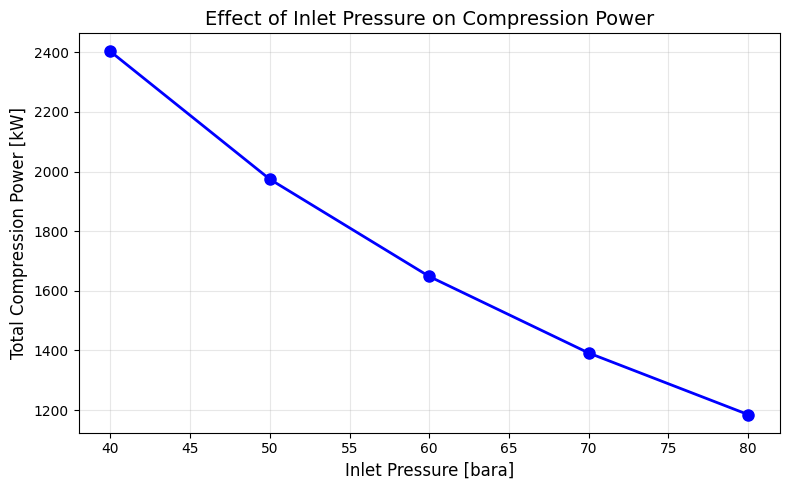

In [7]:
import matplotlib.pyplot as plt

# Store results
inlet_pressures = [40, 50, 60, 70, 80]
total_powers = []

for p_inlet in inlet_pressures:
    # Update feed pressure
    feed.setPressure(float(p_inlet), "bara")
    
    # Re-run simulation
    process.run()
    
    # Calculate total power
    total_power = comp1.getPower('kW') + comp2.getPower('kW')
    total_powers.append(total_power)
    print(f"Inlet P = {p_inlet} bara → Total power = {total_power:.1f} kW")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(inlet_pressures, total_powers, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Inlet Pressure [bara]', fontsize=12)
plt.ylabel('Total Compression Power [kW]', fontsize=12)
plt.title('Effect of Inlet Pressure on Compression Power', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Tips and Best Practices

### Common Patterns

| Task | Code Pattern |
|------|-------------|
| Create EOS fluid | `SystemSrkEos(T_kelvin, P_bara)` |
| Add component | `fluid.addComponent("name", mole_fraction)` |
| Set mixing rule | `fluid.setMixingRule("classic")` |
| Create stream | `Stream("name", fluid)` |
| Get outlet stream | `equipment.getOutletStream()` |
| Get gas from separator | `separator.getGasOutStream()` |
| Get liquid from separator | `separator.getLiquidOutStream()` |

### Temperature and Pressure

- Temperatures in Java API are in **Kelvin** by default
- Use `stream.getTemperature() - 273.15` to convert to Celsius
- Or use `setTemperature(value, "C")` to set in Celsius
- Pressures are in **bara** by default

### Available Equations of State

```python
SystemSrkEos       # Soave-Redlich-Kwong
SystemPrEos        # Peng-Robinson
SystemSrkCPAstatoil # SRK-CPA (for polar/associating components)
SystemUMRPRUMCEos  # UMRPRU (for complex mixtures)
```

### Common Equipment Types

```python
# Separation
Separator, ThreePhaseSeparator, GasScrubber

# Compression/Expansion
Compressor, Expander, ThrottlingValve

# Heat Transfer
Heater, Cooler, HeatExchanger

# Mixing/Splitting
Mixer, Splitter

# Distillation
DistillationColumn, Absorber, Stripper
```

## Next Steps

Explore more NeqSim capabilities:

1. **Recycle streams** - Use `Recycle` for iterative convergence
2. **Three-phase separation** - Handle oil/gas/water systems
3. **Distillation columns** - Use `DistillationColumn` for fractionation
4. **Pipeline simulation** - Use `AdiabaticPipe` or `PipeBeggsAndBrills`
5. **Heat exchangers** - Shell-and-tube heat exchange calculations

See the other example notebooks in this folder for more advanced topics!